# Question 6
With reference to the InsideAirbnb data (i.e. using numbers, figures, maps, and descriptive statistics), what does an analysis of Hosts and the types of properties that they list suggest about the nature of Airbnb lettings in London? To do for final: Add descriptions to each map. 

In [92]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy import stats

In [93]:
##--Airbnb Data--##

airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

airbnb.head(5)

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
0,1126718007114818432,https://www.airbnb.com/rooms/1126718007114818431,2024-06-14,Cozy house in Northolt,Located 1 minute away from a bus stop and 10 m...,380326752,Sadikshya,2020-12-15,NaN,False,...,48.0,3,365,269,0,NaN,NaN,NaN,NaN,POINT (511488.009 183013.814)
1,702589406864297984,https://www.airbnb.com/rooms/702589406864297985,2024-06-15,Up in the sky in London!,"One bedroom with double bed, desk and with th...",77760754,Lena,2016-06-14,"London, United Kingdom",True,...,42.0,1,365,146,83,2023-08-30,2024-06-13,4.94,8.56,POINT (536180.695 185752.726)
2,1122535727514526720,https://www.airbnb.com/rooms/1122535727514526769,2024-06-14,Luxury Stays in SE London (2bed),Welcome to Our Home has recently refurbished o...,322107481,"Nick And Sandy,",2019-12-29,NaN,False,...,150.0,6,365,162,0,NaN,NaN,NaN,NaN,POINT (541020.586 170091.026)
3,904867371314200192,https://www.airbnb.com/rooms/904867371314200140,2024-06-14,"Free Parking: Luxury, Comfy, Near Airport, Net...",Delight in elegance near Heathrow. Sink into t...,517837625,Suite,2023-06-02,"London, United Kingdom",True,...,104.0,2,1125,208,14,2023-06-08,2024-05-17,4.93,1.13,POINT (506216.561 179804.232)
4,809481748064671744,https://www.airbnb.com/rooms/809481748064671711,2024-06-15,4 min walk from the station 1 bedroom apartment,This indipendent apartment has a style. Well ...,30949469,Elisa,2015-04-10,"London, United Kingdom",False,...,82.0,1,95,65,5,2024-04-21,2024-05-26,5.00,2.68,POINT (536185.87 187333.241)


In [94]:
#London Ward Profiles 
##--London Ward Profiles--##

ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

#including only selected variables
ward_profiles = ward_profiles[['Ward name', 'New code','Average Public Transport Accessibility score - 2014','Median House Price (£) - 2014','Median Household income estimate (2012/13)','(ID2010) - Rank of average score (within London) - 2010','(ID2010) % of LSOAs in worst 50% nationally - 2010','Average GCSE capped point scores - 2014',
    '% BAME - 2011','Number of Household spaces - 2011']]

ward_profiles.head(2)

,Ward name,New code,Average Public Transport Accessibility score - 2014,Median House Price (£) - 2014,Median Household income estimate (2012/13),(ID2010) - Rank of average score (within London) - 2010,(ID2010) % of LSOAs in worst 50% nationally - 2010,Average GCSE capped point scores - 2014,% BAME - 2011,Number of Household spaces - 2011
0,City of London,E09000001,7.9,765000.0,63620.0,551.0,20.0,354.5,21.4,5530
1,Barking and Dagenham - Abbey,E05000026,6.0,173000.0,33920.0,166.0,85.7,317.7,71.9,4753


In [95]:
#filtering data 
from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

In [96]:
##--Wards Geometry Data--##

wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE", "HECTARES", "geometry"]]
boroughs = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp").to_crs(epsg=27700)[["NAME", "GSS_CODE", "geometry"]]


inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]
inner_boroughs = boroughs[boroughs['NAME'].isin(inner_london_boroughs)]

# Distribution of Airbnb listings in London 
Minimum nights: 30 days
Last review: 6 months ago
Availability: 90 days
Property Type: All 

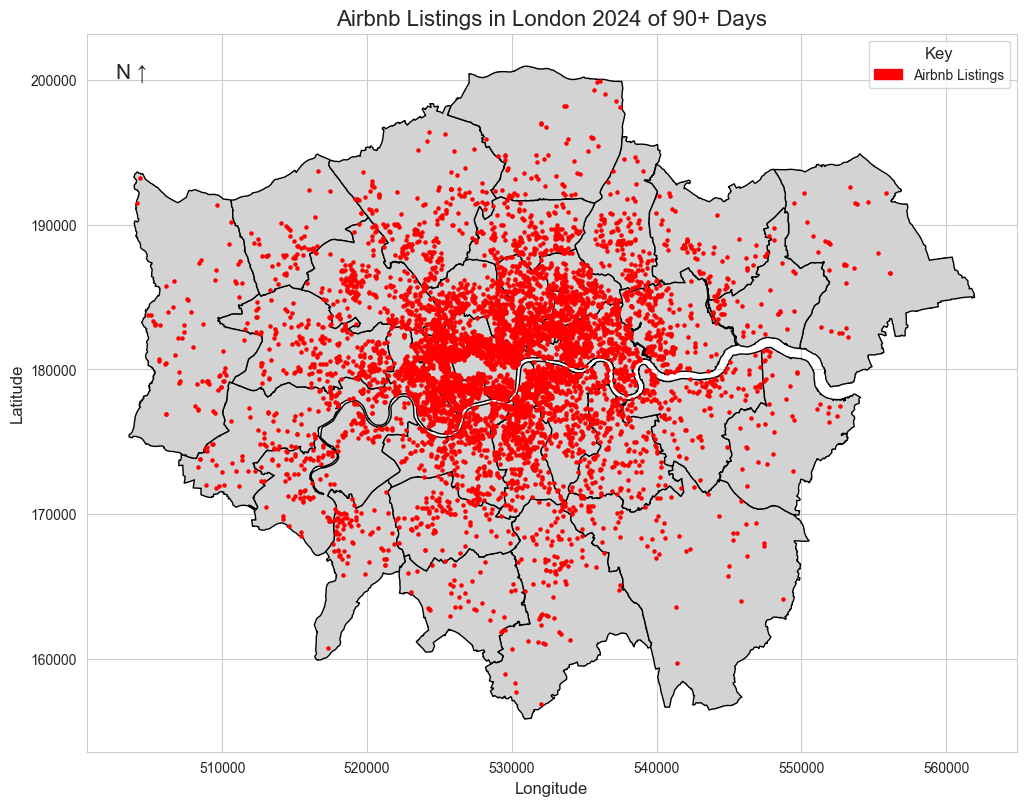

In [97]:
# Plotting the boroughs on map 
fig, ax = plt.subplots(figsize=(12, 12))
boroughs.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plotting the Airbnb points on top of the borough map
filtered_airbnb.plot(ax=ax, color="red", markersize=5, label="Airbnb Listings")

# Adding x and y axis labels for longitude and latitude
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Adding title
plt.title("Airbnb Listings in London 2024 of 90+ Days", fontsize=16)

# Addding a custom north arrow to the top-left corner
north_arrow = AnchoredText("N ↑", loc="upper left", prop=dict(size=15), frameon=False, borderpad=1)
ax.add_artist(north_arrow)

# Adding the Key
airbnb_patch = mpatches.Patch(color="red", label="Airbnb Listings")
legend = ax.legend(handles=[airbnb_patch], title="Key", title_fontsize=12, fontsize=10, loc="upper right")

# Showing the map
plt.show()

# Airbnb Listings in each Borough 



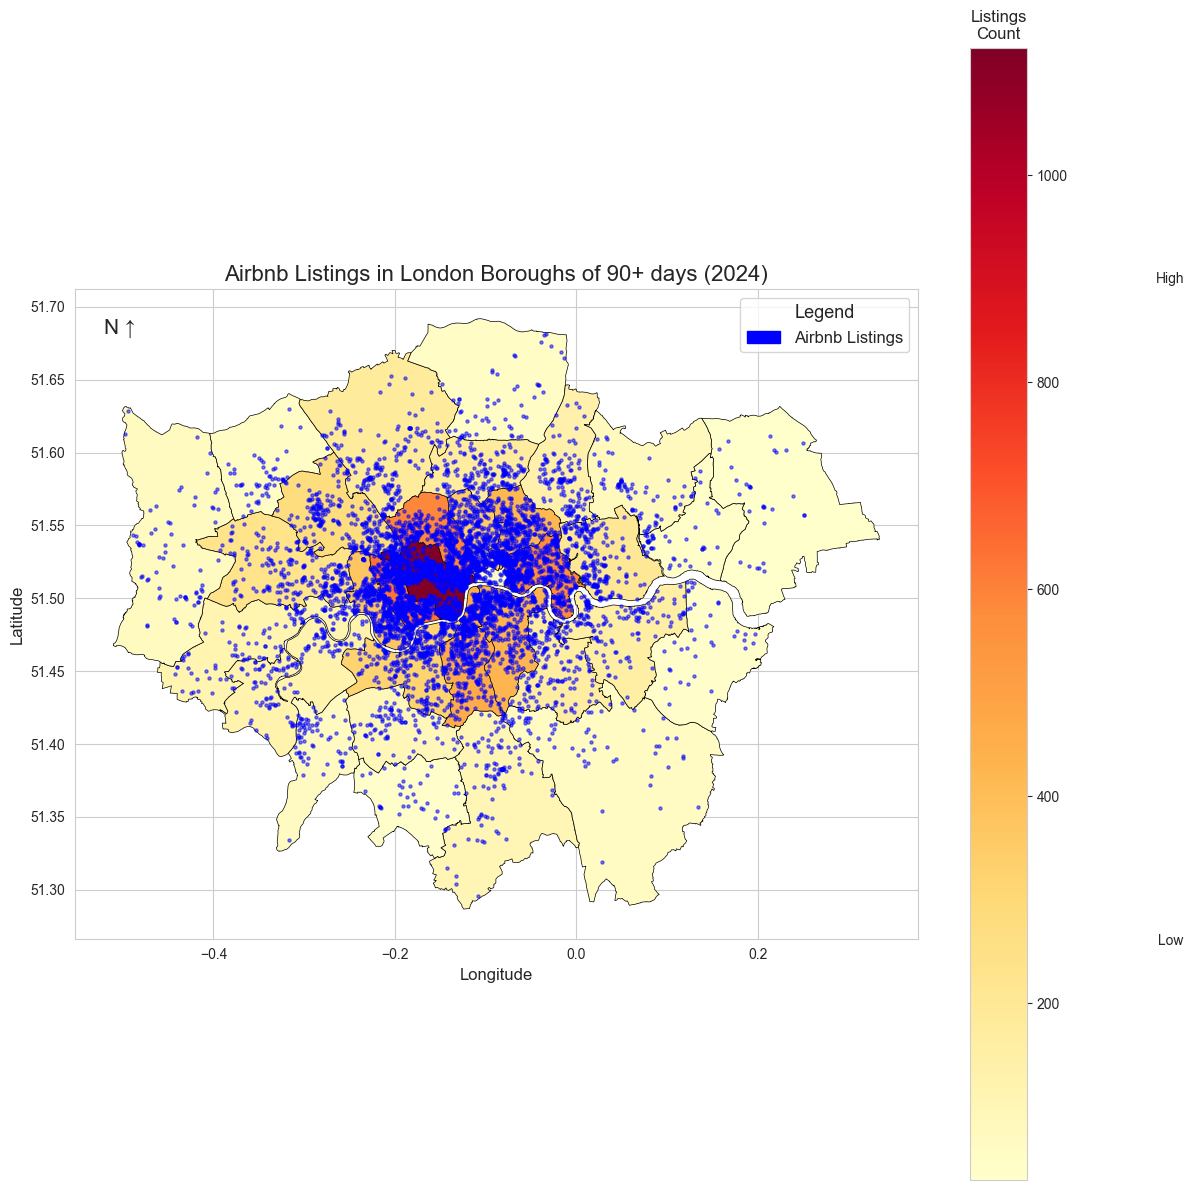

In [98]:
# Ensure boroughs have a CRS set
if boroughs.crs is None:
    boroughs.set_crs(epsg=27700, inplace=True)  # Assuming original CRS is EPSG:27700
boroughs = boroughs.to_crs(epsg=4326)  # Reproject to WGS84 (latitude/longitude)

# Ensure Airbnb data is a GeoDataFrame and set CRS if missing
if filtered_airbnb.crs is None:
    filtered_airbnb = gpd.GeoDataFrame(
        filtered_airbnb,
        geometry=filtered_airbnb.geometry,
        crs="EPSG:27700"  # Assuming original CRS is EPSG:27700
    )
filtered_airbnb = filtered_airbnb.to_crs(epsg=4326)  # Reproject to WGS84

# Perform spatial join to assign each Airbnb to a borough
airbnb_in_boroughs = gpd.sjoin(filtered_airbnb, boroughs, how="inner", predicate="within")

# Count the number of Airbnb listings in each borough
borough_counts = airbnb_in_boroughs.groupby("NAME").size().reset_index(name="Airbnb_Counts")

# Merge the counts back with the boroughs GeoDataFrame
boroughs = boroughs.merge(borough_counts, left_on="NAME", right_on="NAME", how="left")

# Fill NaN values with 0 (in case there are boroughs with no Airbnb listings)
boroughs["Airbnb_Counts"] = boroughs["Airbnb_Counts"].fillna(0)

# Plot the choropleth map with Airbnb points
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the boroughs and shade based on Airbnb counts
choropleth = boroughs.plot(
    column="Airbnb_Counts",
    cmap="YlOrRd",  # Bright red -> orange -> yellow
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Resize and customize the colorbar legend
colorbar = choropleth.get_figure().get_axes()[1]
colorbar.set_title("Listings\nCount", fontsize=12)
colorbar.text(1.3, 1.01, "High", fontsize=10, transform=ax.transAxes, ha="center")
colorbar.text(1.3, -0.01, "Low", fontsize=10, transform=ax.transAxes, ha="center")

# Plot Airbnb points on top
filtered_airbnb.plot(
    ax=ax,
    color="blue",
    markersize=5,
    alpha=0.5,
    label="Airbnb Listings"
)

# Add a north arrow to the top-left corner
north_arrow = AnchoredText("N ↑", loc="upper left", prop=dict(size=15), frameon=False, borderpad=1)
ax.add_artist(north_arrow)

# Customize the legend and place it on the right
airbnb_patch = mpatches.Patch(color="blue", label="Airbnb Listings")
legend = ax.legend(handles=[airbnb_patch], title="Legend", fontsize=12, loc="upper right", title_fontsize=13)

# Add title and labels
plt.title("Airbnb Listings in London Boroughs of 90+ days (2024)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Final adjustments and show the map
plt.tight_layout()
plt.show()


In [99]:
# Listing all airbnb counts by each borough 
# Performing spatial join to assign each Airbnb to a borough
airbnb_in_boroughs = gpd.sjoin(filtered_airbnb, boroughs, how="inner", predicate="within")

# Count the number of Airbnb listings in each borough
borough_counts = airbnb_in_boroughs.groupby("NAME").size().reset_index(name="Airbnb_Counts")

# Fill NaN values with 0 in case of missing boroughs
borough_counts = borough_counts.fillna(0)

# Sort the counts by the number of listings (optional)
borough_counts = borough_counts.sort_values(by="Airbnb_Counts", ascending=False)

# Print the borough names and Airbnb counts
print("Boroughs with Airbnb Counts:")
print(borough_counts)

# Save the result to a CSV file (optional)
borough_counts.to_csv("airbnb_counts_by_borough.csv", index=False)


Boroughs with Airbnb Counts:
                      NAME  Airbnb_Counts
32             Westminster           1123
19  Kensington and Chelsea            629
5                   Camden            586
29           Tower Hamlets            578
21                 Lambeth            463
27               Southwark            429
11                 Hackney            421
12  Hammersmith and Fulham            367
18               Islington            348
31              Wandsworth            320
3                    Brent            279
8                   Ealing            233
24                  Newham            200
1                   Barnet            182
13                Haringey            171
22                Lewisham            163
10               Greenwich            155
30          Waltham Forest            135
26    Richmond upon Thames            125
17                Hounslow            118
7                  Croydon            104
23                  Merton             91
25   

# Calculating the Average Price of Airbnb Listings in London Boroughs


Average Price of Airbnb Listings per Borough:
                      NAME  Average_Price
32             Westminster          321.0
19  Kensington and Chelsea          284.0
6           City of London          233.0
5                   Camden          202.0
31              Wandsworth          179.0


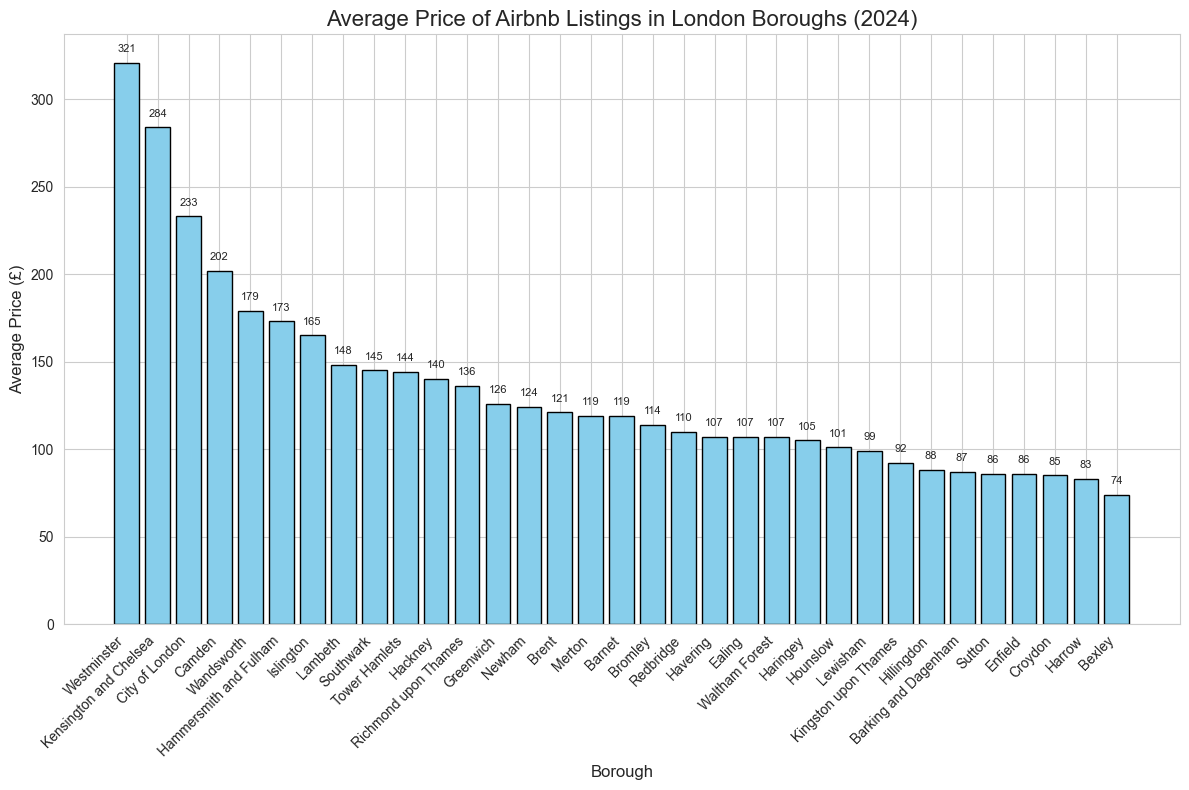

In [100]:
# Calculate the average price of Airbnb listings in each borough
borough_prices = airbnb_in_boroughs.groupby("NAME")["price"].mean().reset_index(name="Average_Price")

# Round the average price to whole numbers
borough_prices["Average_Price"] = borough_prices["Average_Price"].round(0)

# Sort the boroughs by average price for a cleaner plot
borough_prices = borough_prices.sort_values(by="Average_Price", ascending=False)

# Debug: Print the first few rows of average prices
print("Average Price of Airbnb Listings per Borough:")
print(borough_prices.head())

# Plot the average price as a bar graph
plt.figure(figsize=(12, 8))
plt.bar(borough_prices["NAME"], borough_prices["Average_Price"], color="skyblue", edgecolor="black")

# Add titles and labels
plt.title("Average Price of Airbnb Listings in London Boroughs (2024)", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Average Price (£)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Add data labels on top of each bar
for i, value in enumerate(borough_prices["Average_Price"]):
    plt.text(i, value + 5, f"{int(value)}", ha="center", va="bottom", fontsize=8)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


# Properties Rented for over 90+ days
Filter set to - Entire home/apt

Total number of properties rented for over 90 days: 42610
Main Room Types Rented for Over 90 Days:
         Room Type  Count
0  Entire home/apt  28185
1     Private room  14093
2      Shared room    195
3       Hotel room    137


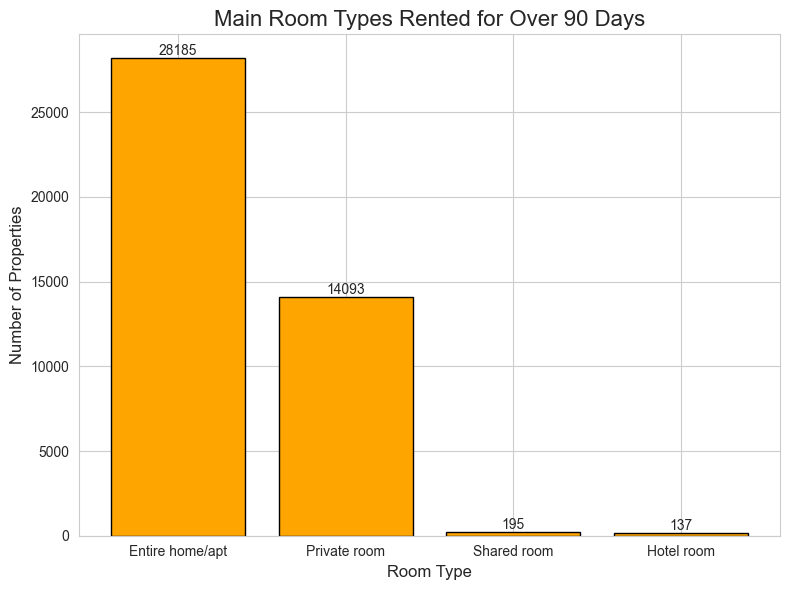

In [101]:
# Filter the Airbnb data to include only properties rented for over 90 days
rented_over_90 = airbnb[airbnb["availability_365"] > 90]

# Determine the number of properties rented for over 90 days
num_properties_over_90 = len(rented_over_90)
print(f"Total number of properties rented for over 90 days: {num_properties_over_90}")

# Group by room type to determine the main room types rented for over 90 days
room_type_counts = rented_over_90["room_type"].value_counts().reset_index()
room_type_counts.columns = ["Room Type", "Count"]

# Print the main room types rented for over 90 days
print("Main Room Types Rented for Over 90 Days:")
print(room_type_counts)

# Plot the main room types as a bar graph
plt.figure(figsize=(8, 6))
plt.bar(room_type_counts["Room Type"], room_type_counts["Count"], color="orange", edgecolor="black")

# Add titles and labels
plt.title("Main Room Types Rented for Over 90 Days", fontsize=16)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)

# Add data labels on top of each bar
for i, value in enumerate(room_type_counts["Count"]):
    plt.text(i, value + 5, str(value), ha="center", va="bottom", fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Hosts with Multiple Listings

In [102]:
# Filter hosts with total listings greater than 2
hosts_with_2plus_listings = airbnb[airbnb["host_listings_count"] >= 2]

# Group by host_name and aggregate total listings
hosts_summary = hosts_with_2plus_listings.groupby("host_name").agg(
    total_listings=("host_listings_count", "first")
).reset_index()

# Calculate required metrics
total_hosts = hosts_summary.shape[0]
average_listings = hosts_summary["total_listings"].mean()
max_listings = hosts_summary["total_listings"].max()
min_listings = hosts_summary["total_listings"].min()

# Find the host(s) with the most listings
host_with_max_listings = hosts_summary[hosts_summary["total_listings"] == max_listings]

# Print the results
print(f"Total number of hosts with more than 2 listings: {total_hosts}")
print(f"Average number of listings per host: {average_listings:.2f}")
print(f"Maximum number of listings: {max_listings}")
print(f"Minimum number of listings (2 or more): {min_listings}")

print("\nHost(s) with the most listings:")
print(host_with_max_listings)



Total number of hosts with more than 2 listings: 6253
Average number of listings per host: 7.06
Maximum number of listings: 1253
Minimum number of listings (2 or more): 2

Host(s) with the most listings:
                   host_name  total_listings
5518  Sykes Holiday Cottages            1253
